# Caterva performance against Zarr and HDF5

This benchmark is meant for comparing speeds of getting hyperplanes on a multidimensional
array using different backends: Caterva, zarr and HDF5.


In [46]:
import cat4py as cat
import zarr
import numcodecs
import tables
import numpy as np
from time import time
import matplotlib.pyplot as plt


In [47]:
# Dimensions for the arrays
shape = (250, 250, 250)
chunkshape = (250, 10, 100)
blockshape = (80, 10, 50)

# Data type
dtype = "f8"

# Compression properties
cname = "lz4"
clevel = 6
filter = cat.SHUFFLE
nthreads = 4
blocksize = int(np.prod(blockshape))


In [48]:
# Create content for populating arrays
content = np.linspace(0, 1, int(np.prod(shape))).reshape(shape)


In [49]:
# Create and fill a caterva array
t0 = time()
a = cat.asarray(content, chunkshape=chunkshape, blockshape=blockshape,
              cname=cname, clevel=clevel, filters=[filter], nthreads=nthreads)
t1 = time()
print("Time for filling array (caterva): %.3fs ; CRatio: %.1fx" % ((t1 - t0), a.cratio))

# Create and fill a zarr array
t0 = time()
compressor = numcodecs.Blosc(cname=cname, clevel=clevel, shuffle=filter, blocksize=blocksize)
numcodecs.blosc.set_nthreads(nthreads)
z = zarr.empty(shape=shape, chunks=chunkshape, dtype=dtype, compressor=compressor)
z[:] = content
t1 = time()
print("Time for filling array (zarr): %.3fs ; CRatio: %.1fx" % ((t1 - t0), z.nbytes / z.nbytes_stored))

# Create and fill a hdf5 array
t0 = time()
filters = tables.Filters(complevel=clevel, complib="blosc:%s" % cname, shuffle=True)
tables.set_blosc_max_threads(nthreads)
h5f = tables.open_file("compare_getslice.h5", 'w', driver='H5FD_CORE', driver_core_backing_store=0)
h5ca = h5f.create_carray(h5f.root, 'carray', filters=filters, chunkshape=chunkshape, obj=content)
h5f.flush()
t1 = time()
print("Time for filling array (hdf5): %.3fs ; CRatio: %.1fx" % ((t1 - t0), h5ca.size_in_memory / h5ca.size_on_disk))


Time for filling array (caterva): 0.141s ; CRatio: 4.6x
Time for filling array (zarr): 0.098s ; CRatio: 4.5x
Time for filling array (hdf5): 0.201s ; CRatio: 4.8x


In [50]:
# Check that the contents are the same
t0 = time()
for block, info in a.iter_read(chunkshape):
    block_cat = block
    block_zarr = z[info.slice]
    np.testing.assert_array_almost_equal(block_cat, block_zarr)
    block_h5 = h5ca[info.slice]
    np.testing.assert_array_almost_equal(block_cat, block_h5)
t1 = time()
print("Time for checking contents: %.3fs" % (t1 - t0))


Time for checking contents: 0.571s


Exception ignored in: 'cat4py.container_ext.Container.__dealloc__'
Traceback (most recent call last):
  File "<string>", line 1, in __new__
TypeError: argument after ** must be a mapping, not NoneType
Exception ignored in: 'cat4py.container_ext.Container.__dealloc__'
Traceback (most recent call last):
  File "<string>", line 1, in __new__
TypeError: argument after ** must be a mapping, not NoneType
Exception ignored in: 'cat4py.container_ext.Container.__dealloc__'
Traceback (most recent call last):
  File "<string>", line 1, in __new__
TypeError: argument after ** must be a mapping, not NoneType
Exception ignored in: 'cat4py.container_ext.Container.__dealloc__'
Traceback (most recent call last):
  File "<string>", line 1, in __new__
TypeError: argument after ** must be a mapping, not NoneType


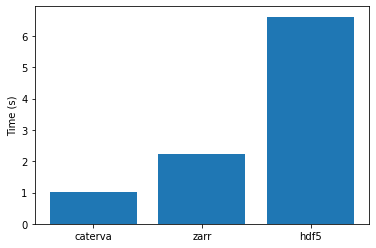

In [51]:
# Setup the coordinates for random planes
planes_idx = np.random.randint(0, shape[0], 100)

# Time getitem with caterva
t0 = time()
for i in planes_idx:
    block = a[i, :, :]
t1 = time()
ctime = t1 - t0

# Time getitem with zarr
t0 = time()
for i in planes_idx:
    block = z[i, :, :]
t1 = time()
ztime = t1 - t0

# Time getitem with hdf5
t0 = time()
for i in planes_idx:
    block = h5ca[i, :, :]
t1 = time()
htime = t1 - t0

plt.bar(["caterva", "zarr", "hdf5"], [ctime, ztime, htime])
plt.ylabel("Time (s)")
plt.show()


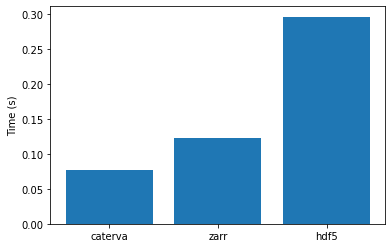

In [52]:
# Setup the coordinates for random planes
planes_idy = np.random.randint(0, shape[1], 100)

# Time getitem with caterva
t0 = time()
for i in planes_idy:
    block = a[:, i, :]
t1 = time()
ctime = t1 - t0

# Time getitem with zarr
t0 = time()
for i in planes_idy:
    block = z[:, i, :]
t1 = time()
ztime = t1 - t0

# Time getitem with hdf5
t0 = time()
for i in planes_idy:
    block = h5ca[:, i, :]
t1 = time()
htime = t1 - t0

plt.bar(["caterva", "zarr", "hdf5"], [ctime, ztime, htime])
plt.ylabel("Time (s)")
plt.show()


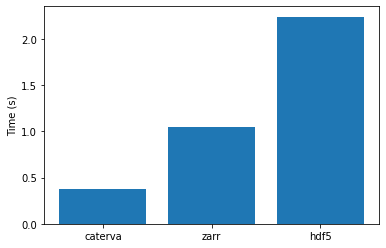

In [53]:
# Setup the coordinates for random planes
planes_idz = np.random.randint(0, shape[2], 100)

# Time getitem with caterva
t0 = time()
for i in planes_idz:
    block = a[:, :, i]
t1 = time()
ctime = t1 - t0

# Time getitem with zarr
t0 = time()
for i in planes_idz:
    block = z[:, :, i]
t1 = time()
ztime = t1 - t0

# Time getitem with hdf5
t0 = time()
for i in planes_idz:
    block = h5ca[:, :, i]
t1 = time()
htime = t1 - t0

plt.bar(["caterva", "zarr", "hdf5"], [ctime, ztime, htime])
plt.ylabel("Time (s)")
plt.show()

In [54]:
h5f.close()
